In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from ctgan import CTGAN
from ctgan import load_demo
import pandas as pd
from table_evaluator import TableEvaluator
import os
import argparse
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from rdt import HyperTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
import pickle
import copulas
from copulas.multivariate import GaussianMultivariate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier

In [21]:
# load data
df_real = pd.read_csv('../data/diabetes_prediction_dataset.csv')
# transform categorical data into numbers using rdt
ht = HyperTransformer()
ht.detect_initial_config(data=df_real)
ht.fit(df_real)
transformed_data = ht.transform(df_real)

# standardize the data to [-1, 1]
mind = transformed_data.min(axis=0)
standard_real = transformed_data-mind
maxd = standard_real.max(axis=0)
standard_real = standard_real*2/maxd -1
standard_real = standard_real.fillna(0)

# split the data into training, validating, testing sets
df_std = pd.DataFrame(standard_real)
train, test = train_test_split(standard_real, test_size=0.4)
validation, test = train_test_split(test, test_size=0.5)
train.to_csv('../data/diabetes-train-rdt.csv')
test.to_csv('../data/diabetes-test-rdt.csv')

In [23]:
# train a model to predict diabetes using original data
X_train = train.drop('diabetes', axis=1)
y_train = train['diabetes']
X_test = test.drop('diabetes', axis=1)
y_test = test['diabetes']
# model = MLPClassifier(hidden_layer_sizes=(64,32,16), max_iter=50, random_state=42)
model = DecisionTreeClassifier(max_depth=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate the test dataset
accuracy = accuracy_score(y_test, y_pred)
f1_org = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
# Print the evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'f1 score: {f1_org}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.94995
f1 score: 0.7177896814209193
Confusion Matrix:
[[17726   573]
 [  428  1273]]
Classification Report:
              precision    recall  f1-score   support

        -1.0       0.98      0.97      0.97     18299
         1.0       0.69      0.75      0.72      1701

    accuracy                           0.95     20000
   macro avg       0.83      0.86      0.85     20000
weighted avg       0.95      0.95      0.95     20000



In [24]:
# save this model
with open("../model/diabetes-model-DecisionTree.pkl", "wb") as f:
	pickle.dump(model, f)

In [27]:
# define parameters
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=512, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of second order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=6, help="dimensionality of the latent space")
parser.add_argument("--attr_size", type=int, default=16, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen data samples")
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epochs=50, batch_size=512, lr=0.002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=6, attr_size=16, channels=1, sample_interval=400)


In [28]:
# train a simple encoder-decoder model to augment data
data_in = Input(shape=(opt.attr_size,))
encoded = Dense(opt.latent_dim, activation='tanh')(data_in)
decoded = Dense(opt.attr_size, activation='tanh')(encoded)
autoencoder = Model(data_in, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(train, train, epochs=50, batch_size=128, validation_data=(validation, validation))
encoder_model = Model(data_in, encoded)

Epoch 1/50
469/469 [==============================] - 1s 2ms/step - loss: 0.3929 - val_loss: 0.1977
Epoch 2/50
469/469 [==============================] - 1s 1ms/step - loss: 0.1587 - val_loss: 0.1310
Epoch 3/50
469/469 [==============================] - 1s 1ms/step - loss: 0.1191 - val_loss: 0.1061
Epoch 4/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0960 - val_loss: 0.0836
Epoch 5/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0753 - val_loss: 0.0663
Epoch 6/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0613 - val_loss: 0.0555
Epoch 7/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0523 - val_loss: 0.0481
Epoch 8/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0457 - val_loss: 0.0423
Epoch 9/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0405 - val_loss: 0.0377
Epoch 10/50
469/469 [==============================] - 1s 1ms/step - loss: 0.0362 - val_loss: 0.0337

In [30]:
# define generator
data_shape = (opt.channels, opt.attr_size)

generator = Sequential()
generator.add(Dense(32, input_dim=opt.latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization(momentum=0.8))
# generator.add(Dense(128, input_dim=opt.latent_dim))
# generator.add(LeakyReLU(0.2))
# generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(opt.attr_size, activation='tanh'))

adam = Adam(learning_rate=opt.lr, beta_1=opt.b1)
generator.compile(loss='binary_crossentropy', optimizer=adam)

# define discriminator
discriminator = Sequential()
discriminator.add(Dense(32, input_dim=opt.attr_size))
discriminator.add(LeakyReLU(0.2))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(16, input_dim=opt.attr_size))
discriminator.add(LeakyReLU(0.2))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# define GAN model
discriminator.trainable = False
ganInput = Input(shape=(opt.latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [31]:
batchCount = train.shape[0]//opt.batch_size
dloss = []
gloss = []
ep = []
# train the GAN model
for e in range(1, opt.n_epochs+1):
    # print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(batchCount)):
        # noise = np.random.normal(0, 1, size=[opt.batch_size, opt.latent_dim])
        dataBatch = train.iloc[np.random.randint(0, train.shape[0], size=opt.batch_size)]
        # dataBatch2 = train.iloc[np.random.randint(0, train.shape[0], size=opt.batch_size)]
        noise_encoder2 = encoder_model.predict(dataBatch)
        generatedData = generator.predict(noise_encoder2)
        d = np.concatenate([dataBatch, generatedData])
        
        yDis = np.zeros(2*opt.batch_size)
        yDis[:opt.batch_size]=0.9
        labelNoise = np.random.random(yDis.shape)
        yDis += 0.05*labelNoise + 0.05
        
        discriminator.trainable=True
        d_loss = discriminator.train_on_batch(d, yDis)
        # noise = np.random.normal(0, 1, size=[opt.batch_size, opt.latent_dim])
        dataBatch3 = train.iloc[np.random.randint(0, train.shape[0], size=opt.batch_size)]
        noise_encoder3 = encoder_model.predict(dataBatch3)
        yGen = np.ones(opt.batch_size)
        discriminator.trainable=False
        g_loss = gan.train_on_batch(noise_encoder3, yGen)
    dloss.append(d_loss)
    gloss.append(g_loss)
    ep.append(e)

100%|██████████| 117/117 [00:19<00:00,  5.96it/s]


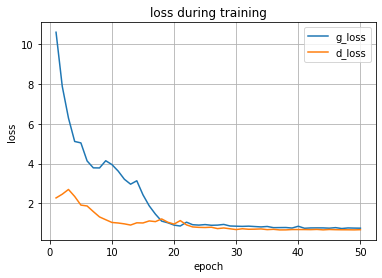

In [32]:
# plot the D loss and G loss
plt.figure()
plt.title('loss during training')
plt.plot(ep, gloss, label='g_loss')
plt.plot(ep, dloss, label='d_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# save the model and loss data
# generator.save('../model/GAN-autoencoder')
model_architecture = generator.to_json()
with open("../model/diabetes-generator1.pkl", "wb") as f:
	pickle.dump(model_architecture, f)
# Save the trained weights
model_weights = generator.get_weights()
with open('../model/diabetes-model-weights1.pkl', 'wb') as f:
    pickle.dump(model_weights, f)
# generator = keras.models.load_model('model/GAN-noise')
loss = np.zeros((len(ep), 3))
loss[:,0]=ep
loss[:,1]=dloss
loss[:,2]=gloss
df_loss = pd.DataFrame(data=loss, columns=['epoch', 'd_loss', 'g_loss'])
df_loss.to_csv('../result/diabetes-gan-loss.csv')

In [34]:
data_sample = train
noise_encoder = encoder_model.predict(data_sample)
generatedData = generator.predict(noise_encoder)
df_synGAN = pd.DataFrame(generatedData, columns=list(test.columns))
df_syn = df_synGAN
df_synGAN += 1
df_synGAN = df_synGAN*maxd/2
df_synGAN += mind
print(df_syn)

       gender_Female  gender_Male  gender_Other  smoking_history_No Info  \
0           1.997315     0.003103      0.000831                 1.662332   
1           0.063255     1.951641      0.000427                 0.163666   
2           1.993557     0.001891      0.000655                 1.426259   
3           0.872350     0.590957      0.000036                 0.008062   
4           0.227896     1.736078      0.000027                 1.846523   
...              ...          ...           ...                      ...   
59995       1.998310     0.000178      0.000082                 0.001929   
59996       0.009341     1.992274      0.000583                 0.032537   
59997       0.000389     1.999934      0.000003                 1.999999   
59998       1.990227     0.001464      0.000128                 1.983541   
59999       1.993870     0.000967      0.000206                 1.971700   

       smoking_history_current  smoking_history_ever  smoking_history_former  \
0      

In [75]:
# convert them back
one_hot_encoded_columns = df_synGAN.iloc[:, :len(one_hot_column_names)].values
original_categorical = preprocessor.named_transformers_['onehot'].inverse_transform(one_hot_encoded_columns)
original_df = pd.DataFrame(original_categorical, columns=categorical_columns)
non_categorical = df_synGAN.drop(columns=one_hot_column_names)
non_1 = non_categorical.iloc[:,:3]
non_2 = non_categorical.iloc[:,3:]
column_names = df_real.columns
all_syn = pd.concat([original_df['gender'], non_1, original_df['smoking_history'], non_2], axis=1, ignore_index=True)
all_syn.columns = column_names
print(all_syn)

       gender        age  hypertension  heart_disease smoking_history  \
0      Female  78.924921      0.906585       0.020676         No Info   
1        Male   7.196297      0.000385       0.002439         current   
2      Female  35.391993      0.160761       0.003112         No Info   
3      Female   6.260439      0.000109       0.000366           never   
4        Male   0.759173      0.000495       0.000220         No Info   
...       ...        ...           ...            ...             ...   
59995  Female  67.410464      0.027731       0.005466           never   
59996    Male  22.642973      0.000187       0.011861         current   
59997    Male  24.392943      0.018549       0.000202         No Info   
59998  Female   4.411609      0.069710       0.000351         No Info   
59999  Female   3.426493      0.072189       0.000266         No Info   

             bmi  HbA1c_level  blood_glucose_level  diabetes  
0      14.722840     6.792767            90.678891  0.014788

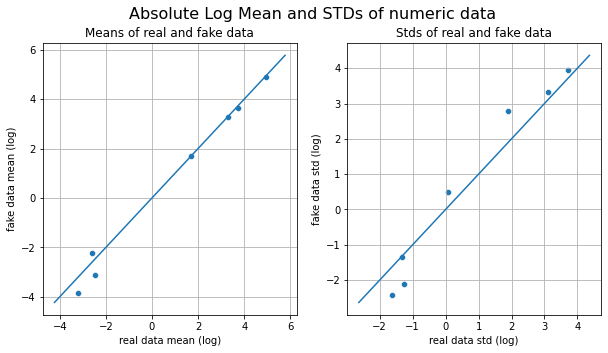

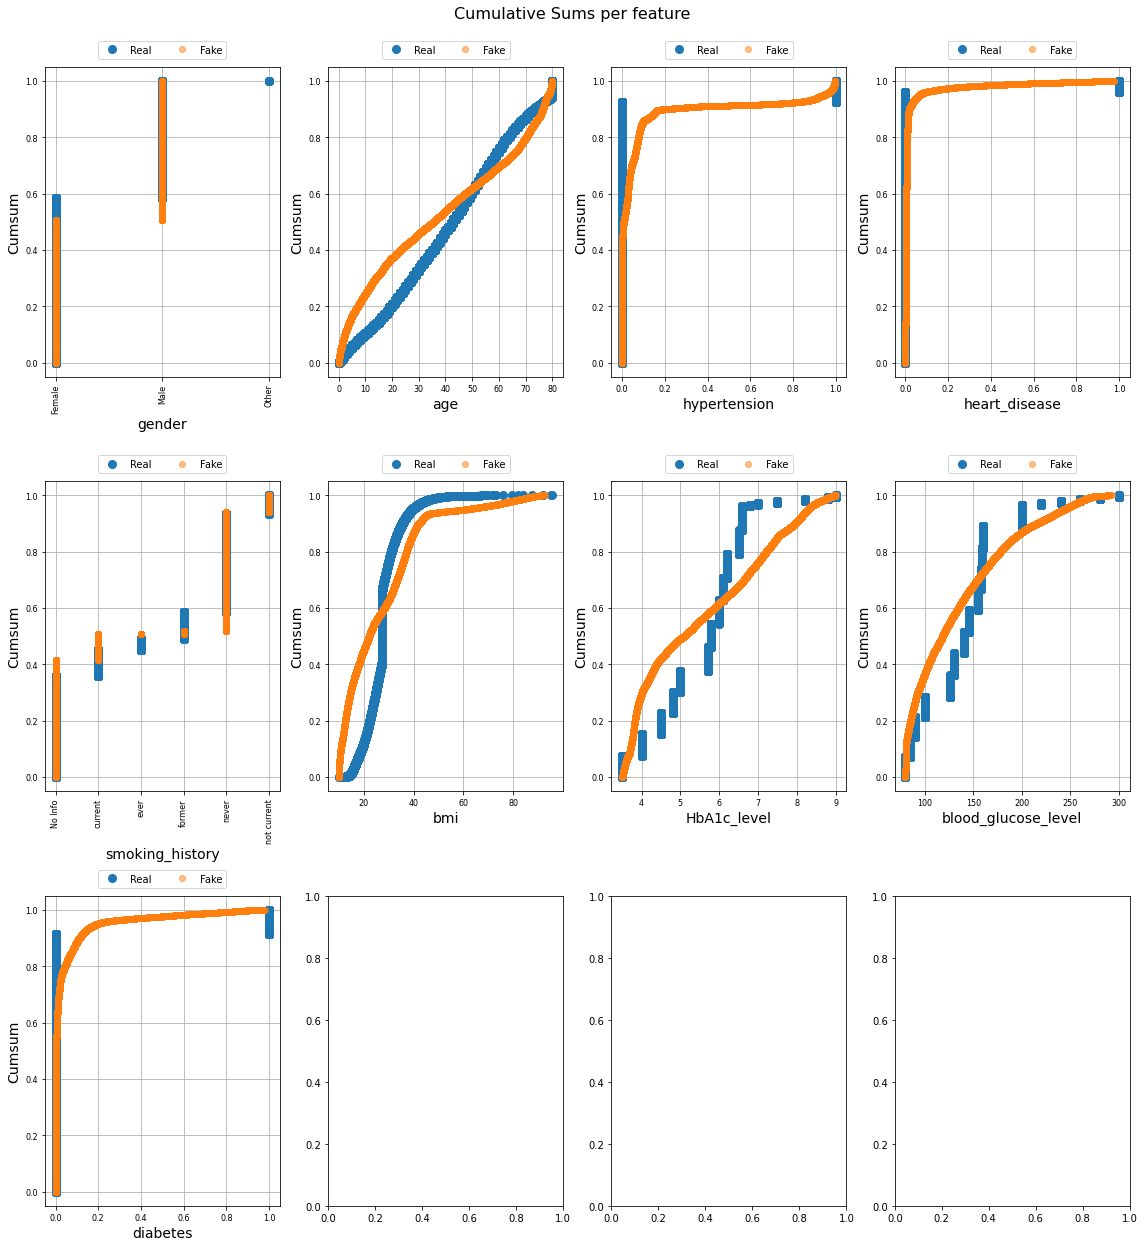

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


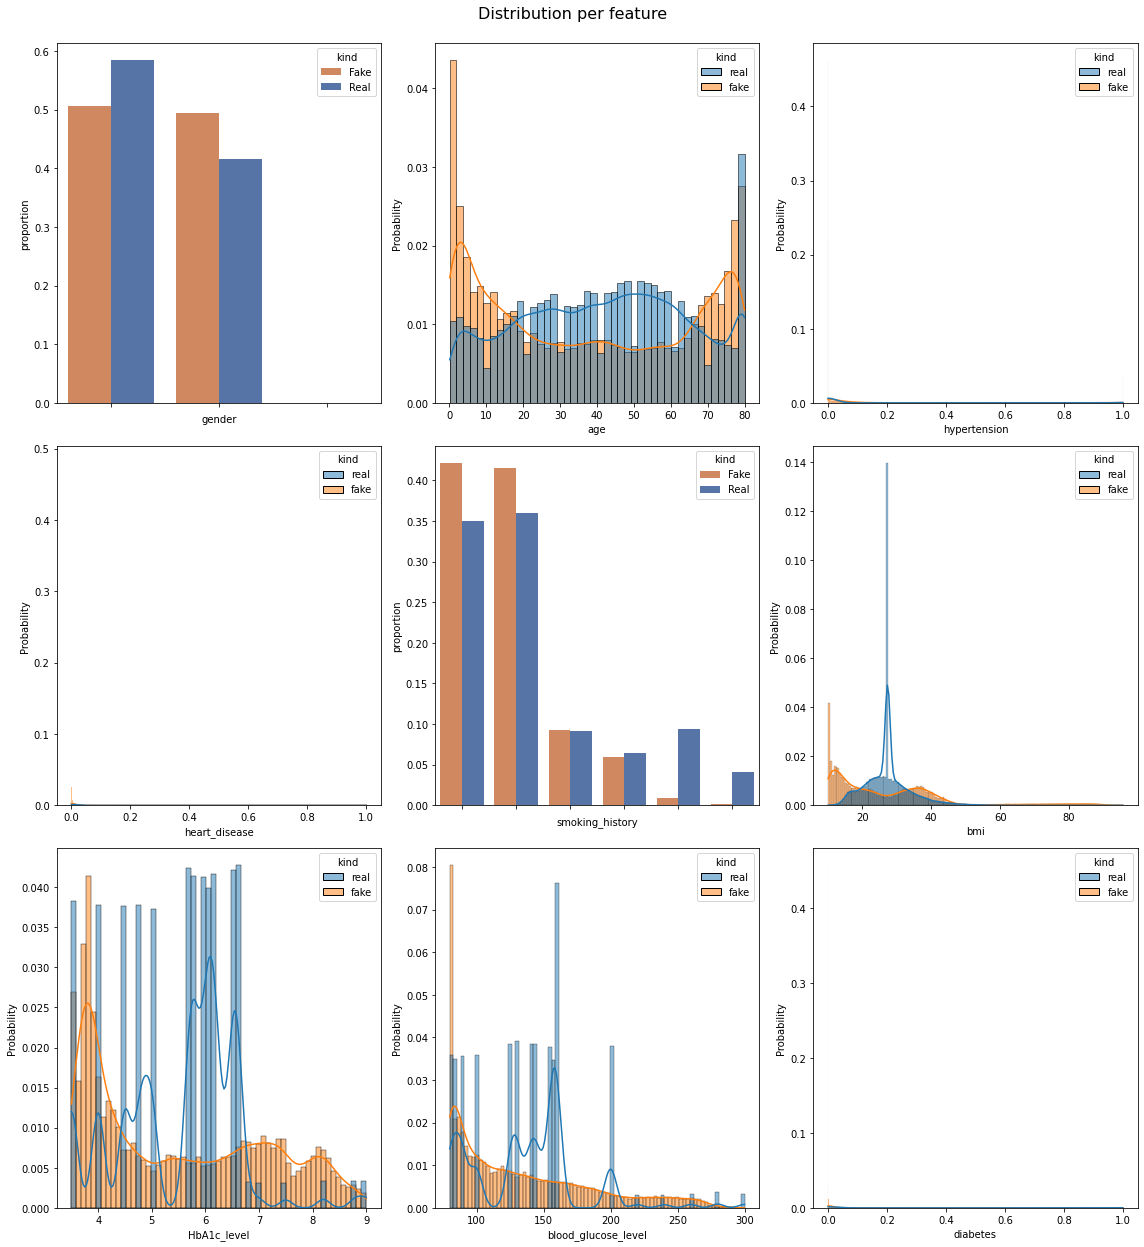

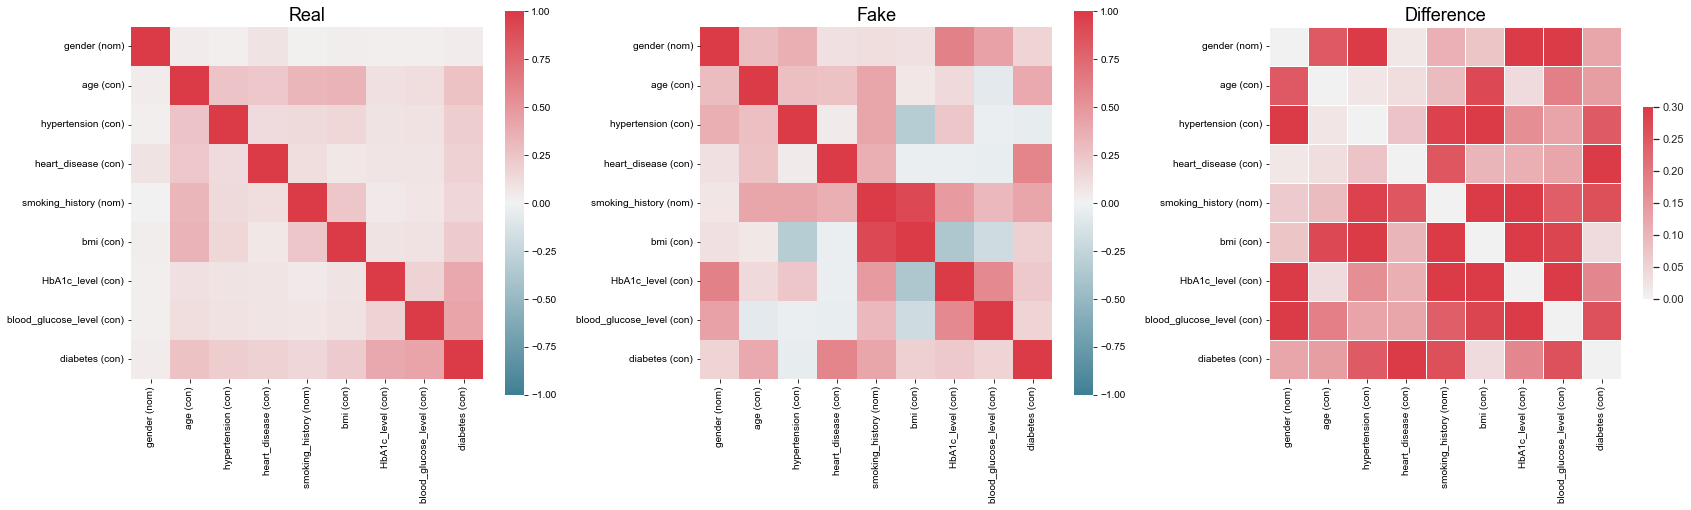

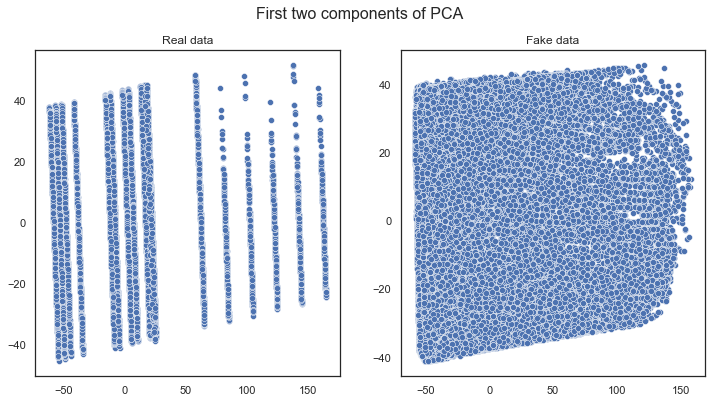

In [76]:
table_evaluator = TableEvaluator(df_real, all_syn)
table_evaluator.visual_evaluation()

In [79]:
gen_x = df_syn.drop('diabetes', axis=1)
gen_y = df_syn['diabetes']
round_y = gen_y.apply(lambda x: -1 if x<0 else 1)
f1_all = [f1_org]
rows_syn = [0]
for i in range(5000,60000,5000):
    x = gen_x.iloc[0:i]
    y = round_y.iloc[0:i]
    nx = np.append(X_train.values, values = x.values, axis=0)
    new_x = pd.DataFrame(nx, columns=list(gen_x.columns))
    ny = np.append(y_train.values, values = y.values, axis=0)
    new_y = pd.DataFrame(ny)
    model2 = DecisionTreeClassifier(max_depth=50)
    model2.fit(new_x, new_y)
    y_pred = model2.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_all.append(f1)
    rows_syn.append(i)

In [80]:
f1_data = np.zeros((len(f1_all), 2))
f1_data[:,0]=rows_syn
f1_data[:,1]=f1_all
df_f1 = pd.DataFrame(data=f1_data, columns=['number of rows', 'f1_score'])
df_f1.to_csv('../result/diabetes-gan-f1-score1.csv')

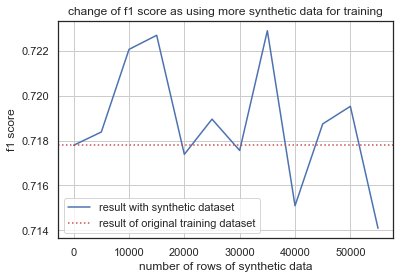

In [81]:
plt.figure()
plt.title('change of f1 score as using more synthetic data for training')
plt.plot(rows_syn, f1_all, label='result with synthetic dataset')
plt.axhline(xmin=0,xmax=2000,y=f1_org, color='r', label='result of original training dataset', linestyle=":")
plt.xlabel('number of rows of synthetic data')
plt.ylabel('f1 score')
plt.legend()
plt.grid()
plt.savefig('../images/diabetes-gan-f1-score.png')
plt.show()

### Copulas

In [82]:
copula = GaussianMultivariate()
copula.fit(train)
synthetic_data = copula.sample(len(train))

df_org = pd.DataFrame(synthetic_data, columns=list(test.columns))
df_o = df_org
df_org += 1
df_org = df_org*maxd/2
df_org += mind

# convert them back
one_hot_encoded_columns = df_org.iloc[:, :len(one_hot_column_names)].values
original_categorical = preprocessor.named_transformers_['onehot'].inverse_transform(one_hot_encoded_columns)
original_df = pd.DataFrame(original_categorical, columns=categorical_columns)
non_categorical = df_org.drop(columns=one_hot_column_names)
non_1 = non_categorical.iloc[:,:3]
non_2 = non_categorical.iloc[:,3:]
column_names = df_real.columns
all_syn = pd.concat([original_df['gender'], non_1, original_df['smoking_history'], non_2], axis=1, ignore_index=True)
all_syn.columns = column_names
print(all_syn)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\optimize.py:700: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_continuous_distns.py:4965: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in mu

       gender        age  hypertension  heart_disease smoking_history  \
0        Male  56.629695  4.830067e-07       0.180482           never   
1      Female  64.502133 -2.319009e-08      -0.030580           never   
2      Female  -5.457444 -3.953100e-08      -0.044522           never   
3      Female  -3.830304  6.720374e-08      -0.074646           never   
4        Male  54.884589 -8.571303e-08      -0.114272         No Info   
...       ...        ...           ...            ...             ...   
59995  Female  67.129262  4.271745e-07      -0.005317         No Info   
59996    Male  60.224951  1.770983e-07       0.294106         No Info   
59997  Female  66.600394  1.922230e-06       0.036571           never   
59998    Male  35.797590  1.195889e-06       0.229976          former   
59999  Female  95.234161  4.328425e-07       0.453080           never   

             bmi  HbA1c_level  blood_glucose_level  diabetes  
0      27.541180     5.323448           146.580592  0.080518

In [84]:
gen_x2 = df_o.drop('diabetes', axis=1)
gen_y2 = df_o['diabetes']
round_y2 = gen_y2.apply(lambda x: -1 if x<0 else 1)
f1_all2 = [f1_org]
rows_syn2 = [0]
for i in range(5000,60000,5000):
    x = gen_x2.iloc[0:i]
    y = round_y2.iloc[0:i]
    nx = np.append(X_train.values, values = x.values, axis=0)
    new_x = pd.DataFrame(nx, columns=list(gen_x2.columns))
    ny = np.append(y_train.values, values = y.values, axis=0)
    new_y = pd.DataFrame(ny)
    model2 = DecisionTreeClassifier(max_depth=50)
    model2.fit(new_x, new_y)
    y_pred = model2.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_all2.append(f1)
    rows_syn2.append(i)

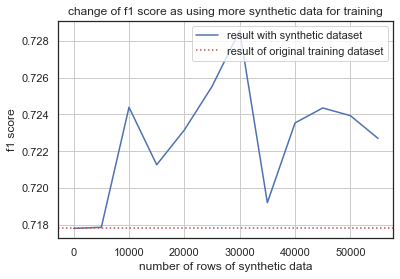

In [85]:
f1_data = np.zeros((len(f1_all2), 2))
f1_data[:,0]=rows_syn2
f1_data[:,1]=f1_all2
df_f1 = pd.DataFrame(data=f1_data, columns=['number of rows', 'f1_score'])

plt.figure()
plt.title('change of f1 score as using more synthetic data for training')
plt.plot(rows_syn2, f1_all2, label='result with synthetic dataset')
plt.axhline(xmin=0,xmax=2000,y=f1_org, color='r', label='result of original training dataset', linestyle=":")
plt.xlabel('number of rows of synthetic data')
plt.ylabel('f1 score')
plt.legend()
plt.grid()
plt.show()

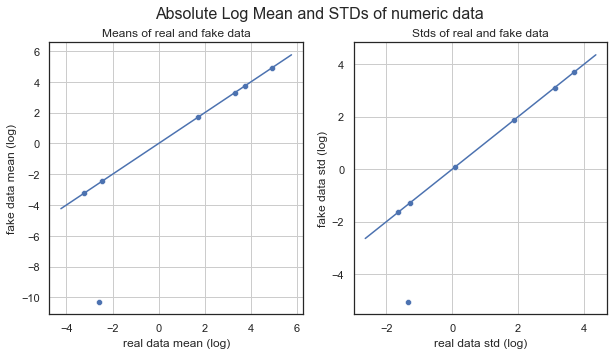

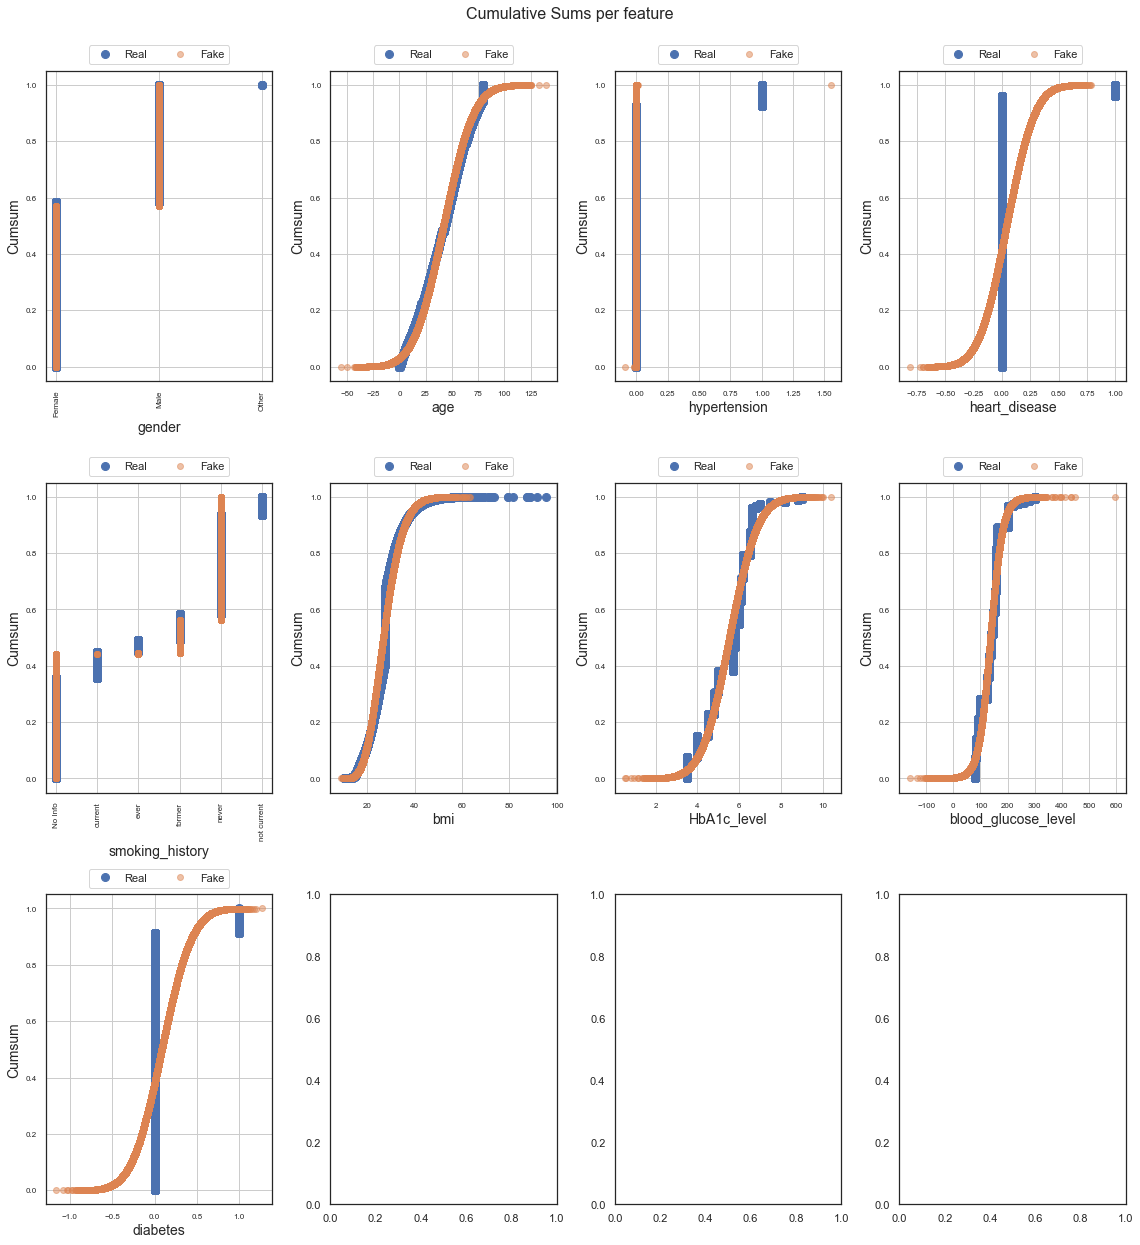

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


MemoryError: Unable to allocate 1.89 GiB for an array with shape (253462630,) and data type int64

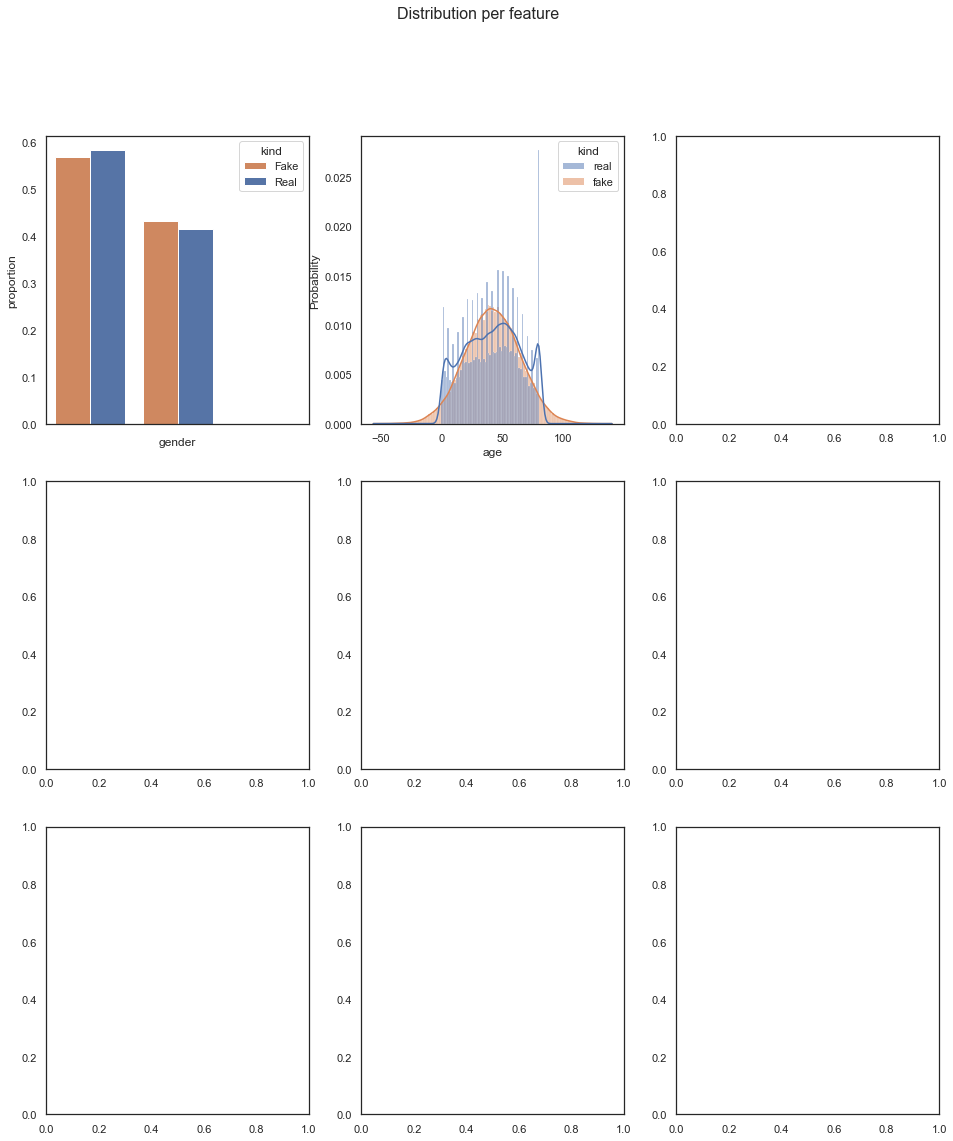

In [86]:
table_evaluator = TableEvaluator(df_real, all_syn)
table_evaluator.visual_evaluation()

### CTGAN

In [88]:
# discrete_columns = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
discrete_columns = ['hypertension', 'heart_disease', 'diabetes'] + list(one_hot_column_names)
ctgan = CTGAN(epochs=10)
ctgan.fit(train, discrete_columns)

In [93]:
samples = ctgan.sample(60000)
# df_samples = pd.DataFrame(synthetic_data, columns=list(test.columns))
df_s = samples
df_s += 1
df_s = df_s*maxd/2
df_s += mind

In [104]:
# convert them back
age_columns = ['gender_Female', 'gender_Male', 'gender_Other']
smoking_columns = ['smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current']
df_no_zeros = df_s.loc[(df_s[age_columns] != 0).any(axis=1)] # drop zero rows
df_no_zeros = df_no_zeros.loc[(df_s[smoking_columns] != 0).any(axis=1)]
one_hot_encoded_columns = df_no_zeros.iloc[:, :len(one_hot_column_names)].values
original_categorical = preprocessor.named_transformers_['onehot'].inverse_transform(one_hot_encoded_columns)
original_df = pd.DataFrame(original_categorical, columns=categorical_columns)
non_categorical = df_no_zeros.drop(columns=one_hot_column_names)
non_1 = non_categorical.iloc[:,:3]
non_2 = non_categorical.iloc[:,3:]
column_names = df_real.columns
all_syn3 = pd.concat([original_df['gender'], non_1, original_df['smoking_history'], non_2], axis=1, ignore_index=True)
all_syn3.columns = column_names
print(all_syn3)

       gender    age  hypertension  heart_disease smoking_history        bmi  \
0        Male  26.00           0.0      -0.000446           never  38.814519   
1        Male    NaN           NaN            NaN         No Info        NaN   
2        Male   1.48           0.0       0.001066           never  27.148786   
3      Female    NaN           NaN            NaN           never        NaN   
4        Male    NaN           NaN            NaN          former        NaN   
...       ...    ...           ...            ...             ...        ...   
59986     NaN  80.00           1.0       0.000193             NaN  27.403444   
59988     NaN  66.00           0.0      -0.001538             NaN  22.658960   
59991     NaN  40.00           0.0      -0.000209             NaN  32.471337   
59995     NaN  45.00           0.0       0.002822             NaN  26.848574   
59997     NaN   7.00           0.0       0.001163             NaN  14.608941   

       HbA1c_level  blood_glucose_level

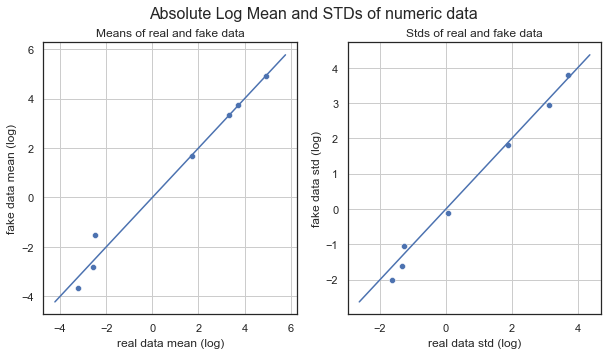

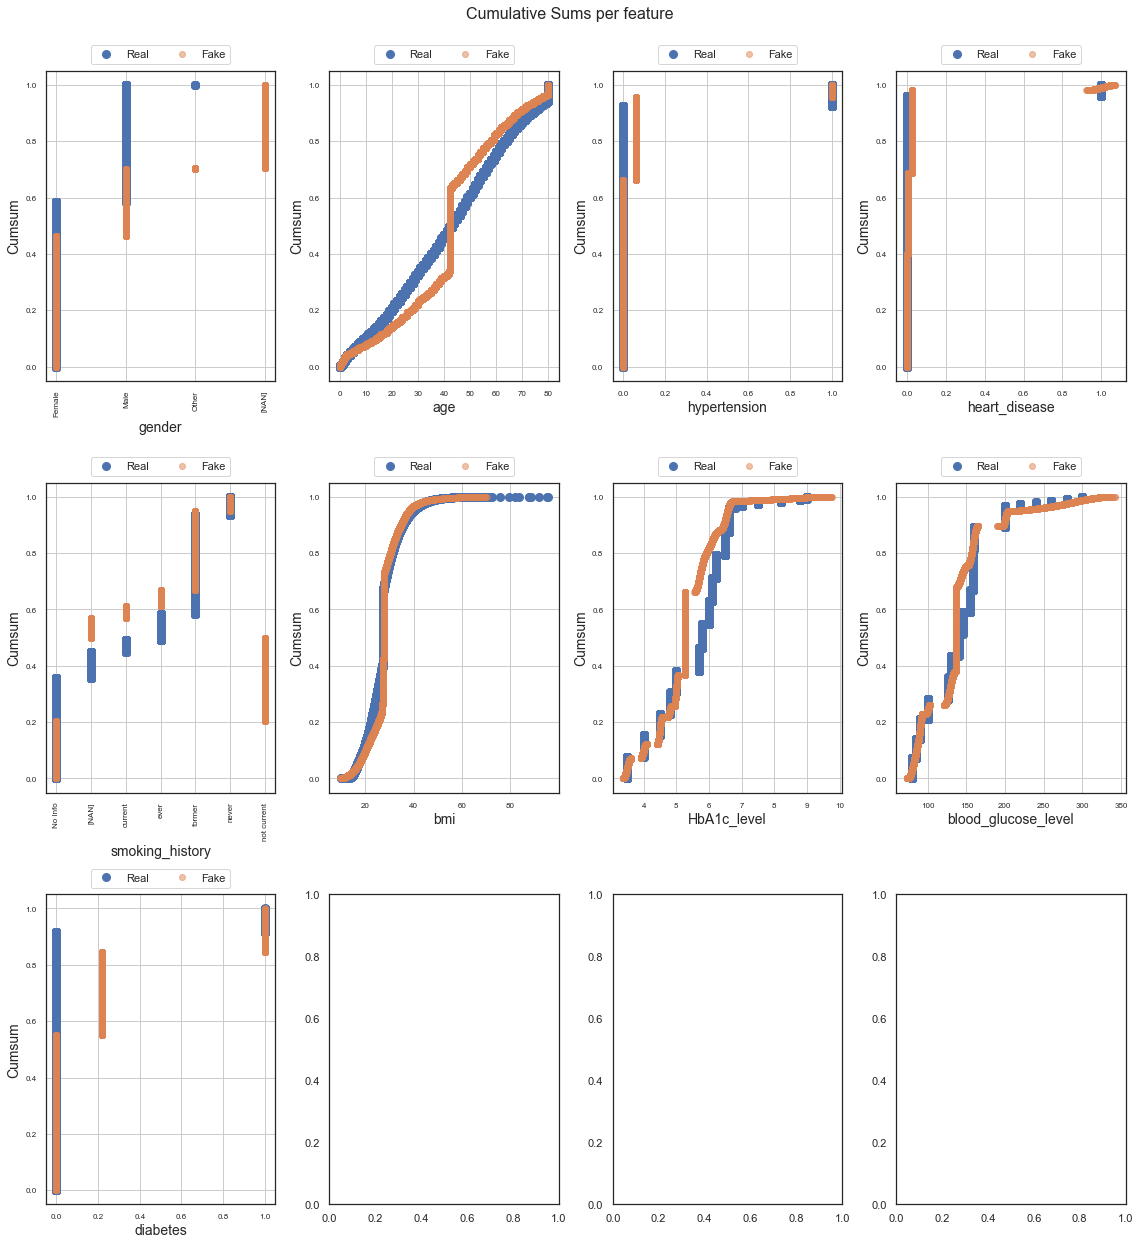

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\table_evaluator\table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


In [105]:
table_evaluator = TableEvaluator(df_real, all_syn3)
table_evaluator.visual_evaluation()

In [32]:
gen_x3 = df_s.drop('diabetes', axis=1)
gen_y3 = df_s['diabetes']
round_y3 = gen_y3.apply(lambda x: -1 if x<0 else 1)
f1_all3 = [f1_org]
rows_syn3 = [0]
for i in range(5000,60000,5000):
    x = gen_x3.iloc[0:i]
    y = round_y3.iloc[0:i]
    nx = np.append(X_train.values, values = x.values, axis=0)
    new_x = pd.DataFrame(nx, columns=list(gen_x3.columns))
    ny = np.append(y_train.values, values = y.values, axis=0)
    new_y = pd.DataFrame(ny)
    model3 = DecisionTreeClassifier(max_depth=50)
    model3.fit(new_x, new_y)
    y_pred = model3.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_all3.append(f1)
    rows_syn3.append(i)

C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: S

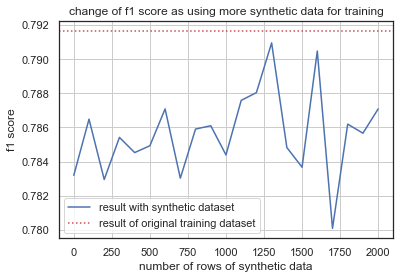

In [33]:
f1_data = np.zeros((len(f1_all3), 2))
f1_data[:,0]=rows_syn3
f1_data[:,1]=f1_all3
df_f1 = pd.DataFrame(data=f1_data, columns=['number of rows', 'f1_score'])

plt.figure()
plt.title('change of f1 score as using more synthetic data for training')
plt.plot(rows_syn3, f1_all3, label='result with synthetic dataset')
plt.axhline(xmin=0,xmax=2000,y=f1_org, color='r', label='result of original training dataset', linestyle=":")
plt.xlabel('number of rows of synthetic data')
plt.ylabel('f1 score')
plt.legend()
plt.grid()
plt.show()